In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
from Data import get_setup
import os
from datetime import datetime
import timeit

import torch.nn.functional as F
import torch
from torch import nn
from torch.utils.data import Dataset
from tqdm import trange
from Data import get_setup
from Inference_new import *
from Models.VI import *
from Tools import uniform_rect_sampler
import argparse


In [3]:
device =torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [4]:
from Metrics import rmse, lpp, batch_entropy_nne, lpp_gaussian


def get_metrics(y_pred, sigma_noise, y_test, std_y_train, time, gaussian_prediction=False):
    metrics = {}
    rmse_test, _ = rmse(y_pred.mean(dim=0).cpu(), y_test.cpu(), std_y_train.cpu())
    metrics.update({'RMSE': rmse_test})

    if gaussian_prediction:
        lpp_test, _ = lpp_gaussian(y_pred.cpu(), y_test.cpu(), sigma_noise.cpu(), std_y_train.cpu())
    else:
        lpp_test, _ = lpp(y_pred.cpu(), y_test.cpu(), sigma_noise.view(1, 1, 1).cpu(), std_y_train.cpu())

    metrics.update({'LPP': lpp_test})
    metrics.update({'time [s]': time})
    metrics.update({'std noise': sigma_noise.item()})
    return metrics

In [5]:
## large ##
# predictive model architecture
layerwidth = 100
nblayers = 1
activation = nn.ReLU()



In [6]:
path="Results/Paper/Exp2/Exp2_large2021-01-29-00:41"

In [16]:
MODELS=torch.load(path+"_models.pt",map_location=device)


In [13]:
datasets = ['navalC', 'powerplant', 'protein']
# for key in MODELS.keys():
#     datasets.append(key)

methods=['Ensemble', 'MC dropout', 'MFVI', 'NN-HyVI', 'FuNN-HyVI', 'FuNN-MFVI']
# for key in MODELS[datasets[0]][0][1].keys():
#     methods.append(key)
    
datasets, methods

(['navalC', 'powerplant', 'protein'],
 ['Ensemble', 'MC dropout', 'MFVI', 'NN-HyVI', 'FuNN-HyVI', 'FuNN-MFVI'])

In [8]:
from Metrics import rmse, lpp, lpp_gaussian
def get_metrics(y_pred, sigma_noise, y_test, std_y_train, time, gaussian_prediction=False):
    metrics = {}
    rmse_test, _ = rmse(y_pred.mean(dim=0).cpu(), y_test.cpu(), std_y_train.cpu())
    metrics.update({'RMSE': rmse_test})

    if gaussian_prediction:
        lpp_test, _ = lpp_gaussian(y_pred.cpu(), y_test.cpu(), sigma_noise.cpu(), std_y_train.cpu())
    else:
        lpp_test, _ = lpp(y_pred.cpu(), y_test.cpu(), sigma_noise.view(1, 1, 1).cpu(), std_y_train.cpu())

    metrics.update({'LPP': lpp_test})
    metrics.update({'time [s]': time})
    metrics.update({'std noise': sigma_noise.item()})
    return metrics

In [18]:
results=[]

#torch.cat([model(x_, 1000).detach() for x_ in x.split(500,dim=0)],dim=0)
for dataset in datasets:   

    for split in MODELS[dataset]:
        split_results={}
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']

        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test)
        metrics = get_metrics(y_pred, torch.tensor(0.), y_test, std_y_train, split[1][method][2], gaussian_prediction=True)
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model.predict(x_test, 1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2], gaussian_prediction=True)
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
            
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=torch.cat([model(x_, 1000).detach() for x_ in x_test.split(100,dim=0)],dim=1)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=torch.cat([model(x_, 1000).detach() for x_ in x_test.split(100,dim=0)],dim=1)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=torch.cat([model(x_, 1000).detach() for x_ in x_test.split(100,dim=0)],dim=1)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=torch.cat([model(x_, 1000).detach() for x_ in x_test.split(100,dim=0)],dim=1)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        #Results.append({dataset:split_results})

In [22]:
torch.save(results,path+'_results.pt')

# RMSE

In [29]:
import pandas as pd

df=pd.DataFrame(results).loc[:,['dataset','method','RMSE']].groupby(['dataset','method']).mean()#.transpose()
df_sem=pd.DataFrame(results).loc[:,['dataset','method','RMSE']].groupby(['dataset','method']).sem()

def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: x[1])
    return df

df_=collapse_columns(df.unstack()).reindex(columns=methods)
df_sem_=collapse_columns(df_sem.unstack()).reindex(columns=methods)
df_.style.background_gradient(axis=1,cmap='viridis_r')
#df_.style.highlight_min(axis=1)


,Ensemble,MC dropout,MFVI,NN-HyVI,FuNN-HyVI,FuNN-MFVI
dataset,,,,,,
navalC,0.000439,0.000548,0.000465,0.000211,0.000208,0.000528
powerplant,3.976920,3.993145,4.086758,3.920541,3.886788,4.152677
protein,4.095686,4.310425,4.240810,4.159647,4.142605,4.343220


In [30]:
for i in df_.columns:
    df_[i] = df_[i].round(3).astype(str)+ "±" + (df_sem_[i].round(3)).astype(str)+""

In [31]:
print(df_.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &     Ensemble &   MC dropout &         MFVI &      NN-HyVI &    FuNN-HyVI &    FuNN-MFVI \\
dataset    &              &              &              &              &              &              \\
\midrule
navalC     &      0.0±0.0 &    0.001±0.0 &      0.0±0.0 &      0.0±0.0 &      0.0±0.0 &    0.001±0.0 \\
powerplant &  3.977±0.062 &  3.993±0.048 &  4.087±0.041 &  3.921±0.054 &  3.887±0.065 &  4.153±0.055 \\
protein    &  4.096±0.024 &   4.31±0.022 &  4.241±0.026 &   4.16±0.029 &  4.143±0.028 &  4.343±0.021 \\
\bottomrule
\end{tabular}



# LPP

In [26]:
import pandas as pd

df=pd.DataFrame(results).loc[:,['dataset','method','LPP']].groupby(['dataset','method']).mean()#.transpose()
df_sem=pd.DataFrame(results).loc[:,['dataset','method','LPP']].groupby(['dataset','method']).sem()

def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: x[1])
    return df

df_=collapse_columns(df.unstack()).reindex(columns=methods)
df_sem_=collapse_columns(df_sem.unstack()).reindex(columns=methods)
df_.style.background_gradient(axis=1,cmap='viridis')
#df_.style.highlight_max(axis=1)


,Ensemble,MC dropout,MFVI,NN-HyVI,FuNN-HyVI,FuNN-MFVI
dataset,,,,,,
navalC,6.120915,5.919015,6.271307,7.032693,7.054551,6.129196
powerplant,-63.117866,-15.899472,-2.827076,-2.786434,-2.778541,-2.844894
protein,-12.095848,-20.011500,-2.864262,-2.844573,-2.840975,-2.887850


In [27]:
for i in df_.columns:
    df_[i] = df_[i].round(3).astype(str)+ "±" + (df_sem_[i].round(3)).astype(str)+""

In [28]:
print(df_.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &       Ensemble &     MC dropout &          MFVI &       NN-HyVI &     FuNN-HyVI &     FuNN-MFVI \\
dataset    &                &                &               &               &               &               \\
\midrule
navalC     &    6.121±0.121 &    5.919±0.125 &   6.271±0.093 &   7.033±0.051 &   7.055±0.054 &   6.129±0.044 \\
powerplant &  -63.118±4.163 &  -15.899±0.533 &  -2.827±0.011 &  -2.786±0.014 &  -2.779±0.018 &  -2.845±0.015 \\
protein    &  -12.096±0.806 &  -20.011±0.581 &  -2.864±0.006 &  -2.845±0.007 &  -2.841±0.007 &  -2.888±0.005 \\
\bottomrule
\end{tabular}



# displaying logs

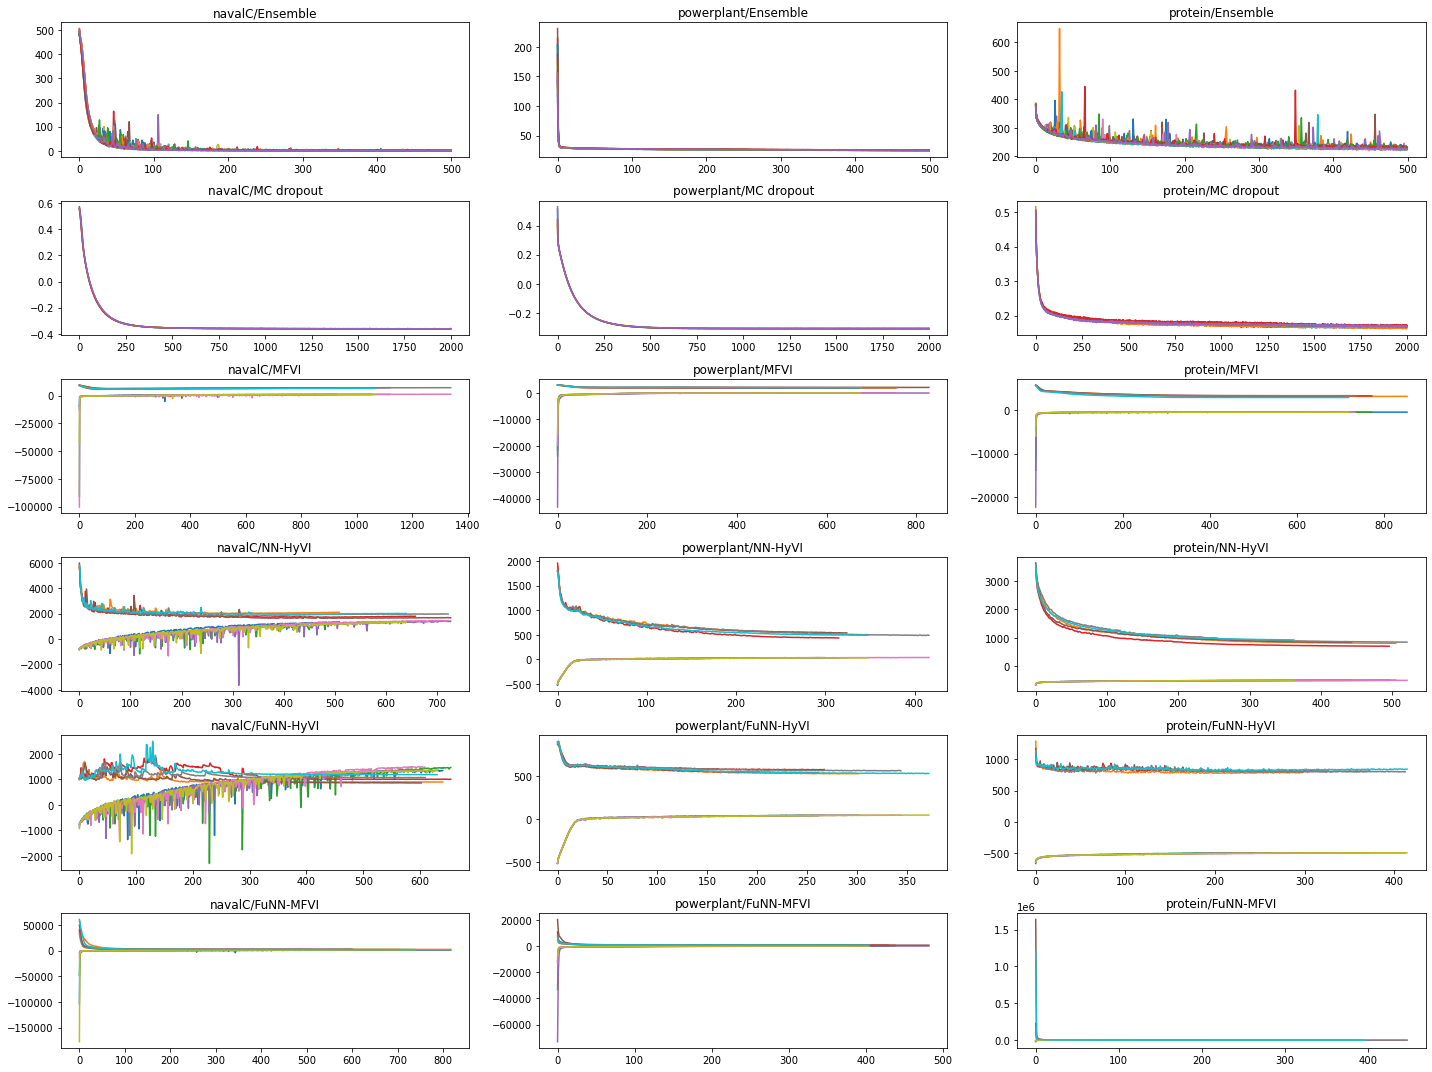

In [32]:
from pylab import *
fig, ax=plt.subplots(len(methods), len(datasets), figsize=(20,15))
ax=ax.flatten()
i=0
for method in methods:
    for dataset in datasets:
        for split in MODELS[dataset]: 
            logs=split[1][method][1]
            for key in logs.keys():
                if key=='KL' or key=='loss' or key=='LL' or isinstance(key, int): 
                    ax[i].plot(range(len(logs[key])), logs[key])
                #ax[i].legend()
                ax[i].set_title(dataset+'/'+method)
        i+=1

fig.tight_layout()

# OOD detection

In [18]:
import math
from Tools import uniform_rect_sampler
from Metrics import batch_entropy_nne

Hs={dataset:{method: [] for method in methods} for dataset in datasets}
#MODELS.to(device)
def Entropy(model, X):
    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]

def univariate_gaussian_entropy(sigma=None, var=None):
    if sigma is not None:
        return 0.5*torch.log(2*math.pi*math.e*sigma**2)
    if var is not None:
        return 0.5*torch.log(2*math.pi*math.e*var)


for dataset in datasets:
    print(dataset)
    split_nb=0
    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        print(split_nb)
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=50000)
        x_OOD=OOD_sampler()
        
        X = [x_train, x_test, x_OOD]

        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        Y = [model(x) for x in X]
        H = [univariate_gaussian_entropy(sigma=y.std(0).squeeze()) for y in Y]  
        Hs[dataset][method].append(H)

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        Y=[torch.cat([model.predict(x_, 1000).detach() for x_ in x.split(500,dim=0)],dim=1) for x in X]
        #Y=[model.predict(x, 1000) for x in X]
        H = [univariate_gaussian_entropy(sigma=y.std(0).squeeze()) for y in Y]  
        Hs[dataset][method].append(H)
         
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][method].append(Entropy(model, X))
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][method].append(Entropy(model, X))

        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][method].append(Entropy(model, X))
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][method].append(Entropy(model, X))
        
        torch.save(Hs,path+'_epist_entropy_50k.pt')

navalC
0


RuntimeError: CUDA out of memory. Tried to allocate 2.98 GiB (GPU 0; 10.76 GiB total capacity; 291.13 MiB already allocated; 2.77 GiB free; 340.00 MiB reserved in total by PyTorch)

In [12]:
H_all=torch.load(path+'epist_entropy.pt')
H_all['protein']=Hs['protein']
torch.save(H_all,path+'_epist_entropy.pt')


In [14]:
Hs=torch.load(path+'_epist_entropy.pt')

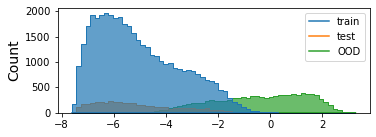

In [15]:
from pylab import *
import seaborn as sns
import pandas as pd

parameters = {'axes.labelsize':14,
              'axes.titlesize': 12,
              'xtick.labelsize' : 10,
              'ytick.labelsize' : 10,
              'figure.titlesize':14}
plt.rcParams.update(parameters)

n_datasets=len(datasets)
n_methods=len(methods)
fig,ax=plt.subplots(n_methods,n_datasets,figsize=(15,11),squeeze=False)

data_type=['train','test','OOD']
method_names=['MC dropout','Ensemble','MFVI','FuNN-MFVI','NN-HyVI','FuNN-HyVI']

label=['train', 'test', 'OOD']
split=1
cmap=plt.get_cmap('Set1')
d=0
for dataset in datasets:
    m=0
    ax[m,d].set_title(dataset)
    for method in methods:
        H=Hs[dataset][method][split]
        #for i in range(len(H)):
        data=pd.DataFrame([pd.Series(H[i].cpu(), name=data_type[i]) for i in range(3)]).transpose()
        #print(data)
 #       data=pd.concat([pd.Series(H[0].cpu(),name='train'),pd.Series(H[1].cpu(),name='test'),pd.Series(H[2].cpu(),name='OOD')], axis=0, join='inner')
#        print(data)
        sns.histplot(data,ax=ax[m,d], stat='count', element='step',common_bins=True, alpha = .7)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],
        sns.ecdfplot(data,ax=ax[m,d])#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],

        if not (m,d) == (3,2): 
            ax[m,d].remove()
        if d ==0:
            if method=='FuNN-HyVI' or method== 'NN-HyVI' or method== 'FuNN-HyVI*':
                ax[m,d].set_ylabel(method, {'fontweight':'bold'})
            else:
                ax[m,d].set_ylabel(method)
        m+=1

    d+=1
#ax[3,2].legend(loc='upper right', prop={'size': 8})#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()
fig.align_ylabels(ax[:, 0])
plt.savefig(path+"_PredictiveEntropy_Exp2-{}.pdf".format(split), dpi=600)
#plt.subplots_adjust(top=.9)
#plt.suptitle('Posterior Predictive Entropy Distributions')
plt.show()

In [34]:
data

0      -6.971229
1      -4.883101
2      -7.050019
3      -7.644053
4      -4.823151
          ...   
9995   -2.884209
9996   -1.897441
9997    0.738550
9998   -7.153877
9999    0.286795
Length: 55730, dtype: float32

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score
from pylab import *
import numpy as np
cmap=plt.get_cmap('Set1')
Hs=H_all
roc_data={dataset:[] for dataset in datasets}
AUC={}
for dataset in datasets:     
    for method in methods:
        AUCs=[]
        for h in Hs[dataset][method]:
            H_in=torch.cat([h[0],h[1]]).cpu()
            H_ood, _=h[2].cpu().sort()
            y_true=torch.cat([torch.ones_like(torch.cat([h[0],h[1]])),torch.zeros_like(h[2])])
            y_score=-torch.cat([h[0],h[1],h[2]])
            AUCs.append(roc_auc_score(y_true.cpu(), y_score.cpu()))

            fpr=torch.arange(len(H_ood)).true_divide(len(H_ood))
            tpr=(H_in.unsqueeze(-1) < H_ood).sum(0).true_divide(len(H_in))
            roc_data[dataset]+=[{'fpr-ood': 0., 'tpr-id':0., 'method':method }]
            roc_data[dataset]+=[{'fpr-ood': fpr[i].item(), 'tpr-id':tpr[i].item(), 'method':method } for i in range(len(fpr))]
        
        AUC.update({(dataset,method):np.mean(AUCs)})
        print(dataset+"/"+method+": {}".format(np.mean(AUCs)))

navalC/Ensemble: 1.0
navalC/MC dropout: 0.9999962577509637
navalC/MFVI: 0.08330434556728675
navalC/NN-HyVI: 0.9047593933299816
navalC/FuNN-HyVI: 0.9983372775263952
navalC/FuNN-MFVI: 0.9872457105748282
powerplant/Ensemble: 0.9313424864130434
powerplant/MC dropout: 0.9181851693143812
powerplant/MFVI: 0.6601641962792643
powerplant/NN-HyVI: 0.9186633664297659
powerplant/FuNN-HyVI: 0.9369706594899665
powerplant/FuNN-MFVI: 0.8956648704013379
protein/Ensemble: 0.9999231441067133
protein/MC dropout: 0.9998679002842771
protein/MFVI: 0.552466758801662
protein/NN-HyVI: 0.9624891495735841
protein/FuNN-HyVI: 0.9966973376339382
protein/FuNN-MFVI: 0.9654444852394489


In [22]:
torch.save(roc_data,path+'_roc_data.pt')
torch.save(AUC,path+'_AUC.pt')


In [31]:
roc_data=torch.load(path+'_roc_data.pt')
AUC=torch.load(path+'_AUC.pt')


In [32]:
import pandas as pd
for dataset in datasets:  
    for entry in roc_data[dataset]:
            entry['method']=entry['method']+", AUC={}".format(AUC[(dataset,entry['method'])].round(3))
data={dataset: pd.DataFrame(roc_data[dataset]) for dataset, roc in roc_data.items()}


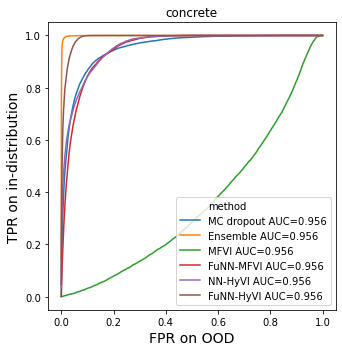

In [61]:
import seaborn as sns
l=len(datasets)
fig, ax= plt.subplots(1,figsize=(5,5))

dataset='concrete'

sns.lineplot(data=data[dataset], x="fpr-ood", y="tpr-id", hue="method", ax=ax, ci=None)
ax.set_title(dataset)
ax.set_xlabel('FPR on OOD')
ax.set_ylabel('TPR on in-distribution')
ax.set_aspect('equal')


fig.tight_layout()

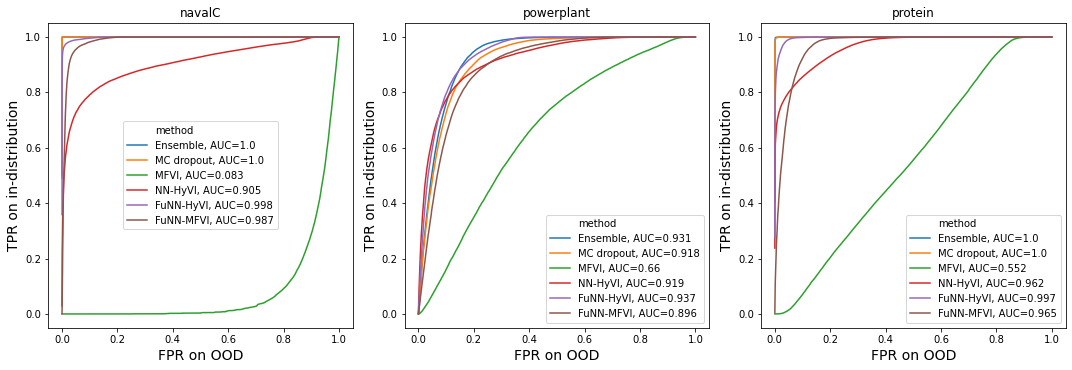

In [33]:
import seaborn as sns
l=len(datasets)
fig, ax= plt.subplots(1,l,figsize=(5*l,5))
d=0
cmap=plt.get_cmap('Set1')

for dataset in datasets:  
    
    sns.lineplot(data=data[dataset], x="fpr-ood", y="tpr-id", hue="method", ax=ax[d],  ci=None)
        #custom_text.append(method+' (AUC:{})'.format(np.mean(AUCs).round(3)))
    #lgd = ax[d].legend(custom_lines, custom_text, loc='best')
    ax[d].set_title(dataset)
    ax[d].set_xlabel('FPR on OOD')
    ax[d].set_ylabel('TPR on in-distribution')
    ax[d].set_aspect('equal')
    d+=1


fig.tight_layout()

In [34]:
plt.savefig("Results/Paper/Exp2/UCIsmall_ROC_curves_Exp2.pdf", dpi=600)


<Figure size 432x288 with 0 Axes>

In [19]:
2

2